In this project we gonna be building and deploying a deep learning model that can automatically identify and classify different types of surface defects (e.g., scratches, cracks, dents) on metal sheets from images.

In order to acheive this we would be using libraries of python like: tensorflow, matplotlib, opencv-python and gradio

Here's some basic info about them :

tensorflow: The deep learning framework we'll use to build our CNN.

matplotlib: For visualizing images and plots.

opencv-python: A computer vision library useful for image manipulation, though Keras will handle most of the heavy lifting.

gradio: For building the final interactive web UI.

Define Parameters and Load the Data

First, we will define some key parameters like image size and batch size. Then, we'll create two datasets: one for training and one for validation.

In [19]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path('data/')

batch_size = 32
img_height = 200
img_width = 200
image_size = (img_height, img_width)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=image_size,
  batch_size=batch_size)

Found 1656 files belonging to 6 classes.
Using 1325 files for training.
Found 1656 files belonging to 6 classes.
Using 331 files for validation.


validation_split=0.2: We're setting aside 20% of the images for validation.

subset="training" or "validation": This tells the function which part of the split to create.

seed=123: Using the same seed for both datasets ensures there is no overlap between the training and validation images.

Verify the Datasets

In [ ]:
class_names = train_ds.class_names
print("Classes found:", class_names)

Classes found: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


Optimize for Performance

To ensure the model trains efficiently without being held up by data loading, we should configure the datasets with .cache() and .prefetch().

.cache(): Keeps the images in memory after they're loaded off disk during the first epoch.

.prefetch(): Overlaps data preprocessing and model execution. While the model is training on one batch of data, the data pipeline is preparing the next batch.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

We now have two highly efficient tf.data.Dataset objects, train_ds and val_ds, ready to be fed into a neural network.

Exploratory Data Analysis for Images

Now, we'll grab one batch from our train_ds and use matplotlib to plot a grid of the images and their corresponding labels.

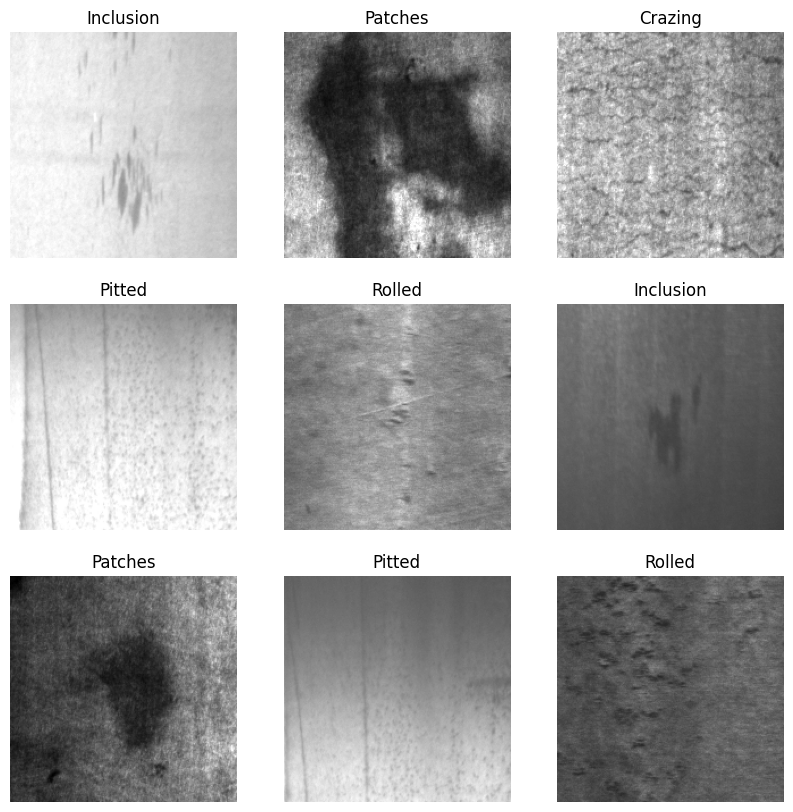

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

Instead of creating new images on our disk, we'll build a data augmentation layer that will be added directly to our model. This layer will apply different random transformations to each batch of images during training.

Define the Augmentation Layer

We'll use Keras preprocessing layers to build a small Sequential model that will handle the augmentation.

In [ ]:
import tensorflow as tf
from tensorflow import keras

img_height = 200
img_width = 200

data_augmentation = keras.Sequential(
  [
    keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
  ]
)
print("Data augmentation model created successfully.")
data_augmentation.summary()

Data augmentation model created successfully.


c:\Users\HP\Desktop\Automated Defect Detection in Manufacturing\add_env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 200, 200, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 200, 200, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

RandomFlip: Randomly flips images either horizontally or vertically.

RandomRotation: Randomly rotates the images by a fraction of 360 degrees (in this case, up to 20%).

RandomZoom: Randomly zooms in or out on the images by up to 20%.

Visualize the Augmentation

To understand what this layer does, let's take one image from our training set and apply the augmentation to it several times to see the different possible outputs.

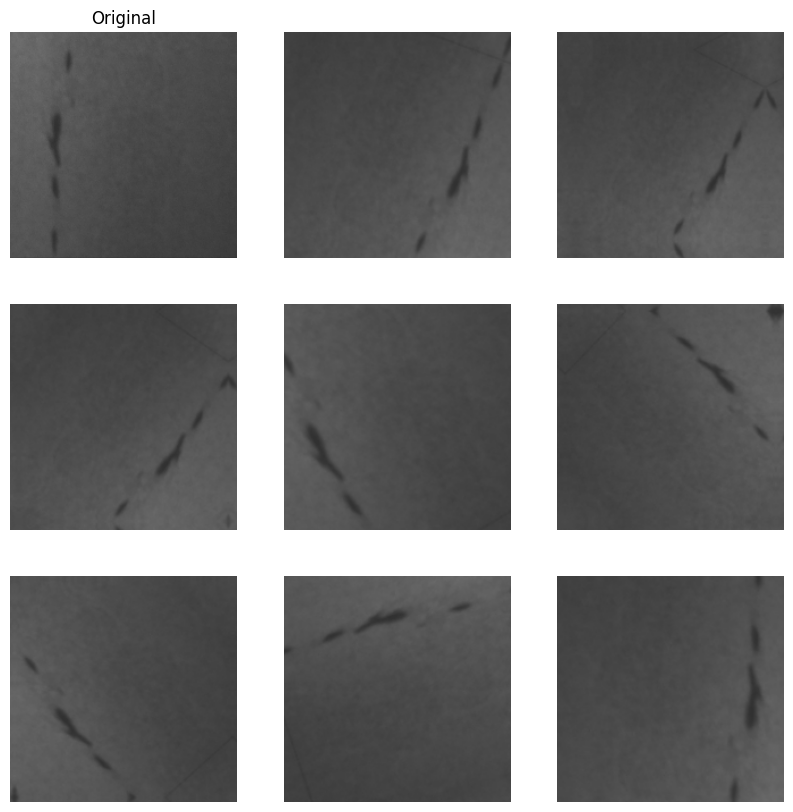

In [13]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  ax = plt.subplot(3, 3, 1)
  plt.imshow(first_image.numpy().astype("uint8"))
  plt.title("Original")
  plt.axis("off")
  
  for i in range(8):
    ax = plt.subplot(3, 3, i + 2)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")
  plt.show()
  break

Now as a result we see the original image followed by eight different, randomly transformed versions of it. This is exactly what the model will see during training, forcing it to learn the essential features of a defect rather than just its orientation in the original picture.

This data_augmentation layer is now ready to be used as the first layer in our main model.

Now we will be taking our model that is already an expert at identifying shapes, edges, and textures (from being trained on millions of images) and just teaching it to recognize our specific types of defects.

Load the Pre-Trained Base Model

We'll use MobileNetV2, a lightweight and effective model pre-trained on the ImageNet dataset. We will load it without its final classification layer (include_top=False) because we need to add our own.

In [14]:
import tensorflow as tf
from tensorflow import keras

num_classes = len(class_names)

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

C:\Users\HP\AppData\Local\Temp\ipykernel_12692\2097162768.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Freeze the Base Model

This is the key to transfer learning. We "freeze" the weights of the pre-trained layers, telling Keras not to update them during our initial training. We will only train the new layers we add.

In [15]:
base_model.trainable = False

Build the Full Model

Now, we'll stack all the pieces together: our data augmentation layer, rescaling layer, the frozen base model, and our new custom classification layers.

In [16]:
model = keras.Sequential([
  data_augmentation,

  keras.layers.Rescaling(1./127.5, offset=-1),

  base_model,

  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Rescaling: Normalizes the image pixel values.

GlobalAveragePooling2D: Flattens the output from the base model into a single vector, preparing it for the final dense layer.

Dropout: A regularization technique to prevent overfitting.

Dense: Our final classification layer with a softmax activation, which will output a probability for each of the six defect classes.

We can notice in the summary that the number of "Trainable params" is very small compared to the "Non-trainable params." This confirms we have successfully frozen the base model.

We now have a complete, state-of-the-art deep learning model ready for the final step.

Compile the Model

Before we can train the model, we need to configure it with a loss function, an optimizer, and metrics to monitor.

Optimizer: We'll use adam, which is a standard, robust choice.

Loss Function: Since this is a multi-class classification problem (an image belongs to one of six classes) and our labels are integers, we use SparseCategoricalCrossentropy.

Metrics: We'll monitor accuracy.

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

Train the Model

Now, we'll feed our training and validation datasets to the model using the .fit() method. The model will learn by iterating over the dataset for a set number of epochs.

In [20]:
# Set the number of epochs to train for
epochs = 20

# Train the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 749ms/step - accuracy: 0.7034 - loss: 0.8697 - val_accuracy: 0.7976 - val_loss: 0.5606
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 763ms/step - accuracy: 0.9577 - loss: 0.2259 - val_accuracy: 0.9063 - val_loss: 0.3058
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 734ms/step - accuracy: 0.9736 - loss: 0.1309 - val_accuracy: 0.9184 - val_loss: 0.2529
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 704ms/step - accuracy: 0.9842 - loss: 0.1033 - val_accuracy: 0.9275 - val_loss: 0.2317
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 704ms/step - accuracy: 0.9887 - loss: 0.0859 - val_accuracy: 0.9215 - val_loss: 0.2230
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 704ms/step - accuracy: 0.9872 - loss: 0.0688 - val_accuracy: 0.9426 - val_loss: 0.1856
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 715ms/step - accuracy: 0.9879 - loss: 0.0685 - val_accuracy: 0.9396 - val_loss: 0.1867
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 30s 707ms/step - accuracy: 0.9872 - loss: 0.0528 - val_accu

Visualize Training Results

Plotting the training history is the best way to see how our model learned over time and to check for issues like overfitting.

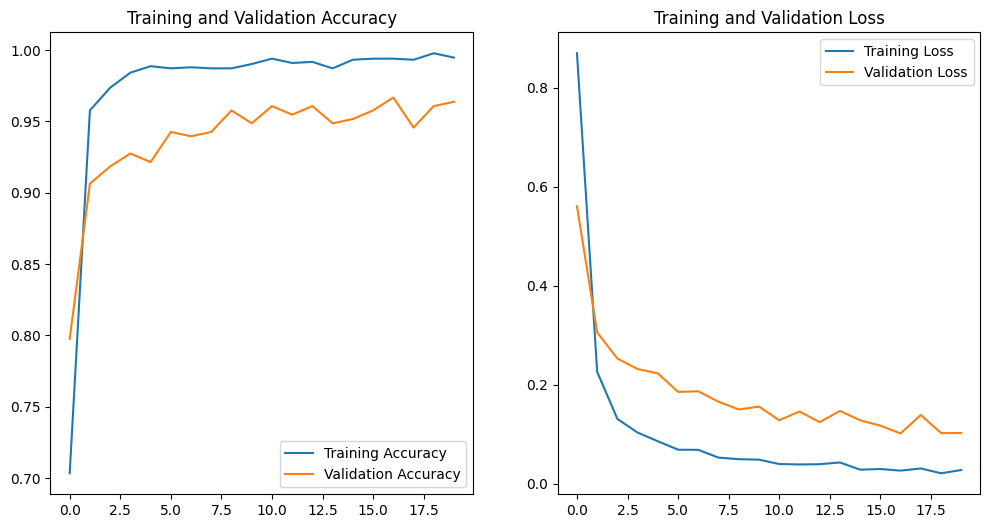

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Ideally we want to see both training and validation accuracy increasing together. If the training accuracy continues to rise while validation accuracy flattens or drops, it's a sign of overfitting.

Evaluate the Final Model

Finally, let's get the definitive performance score on our validation data. A confusion matrix is also excellent for seeing which specific defects the model is confusing.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


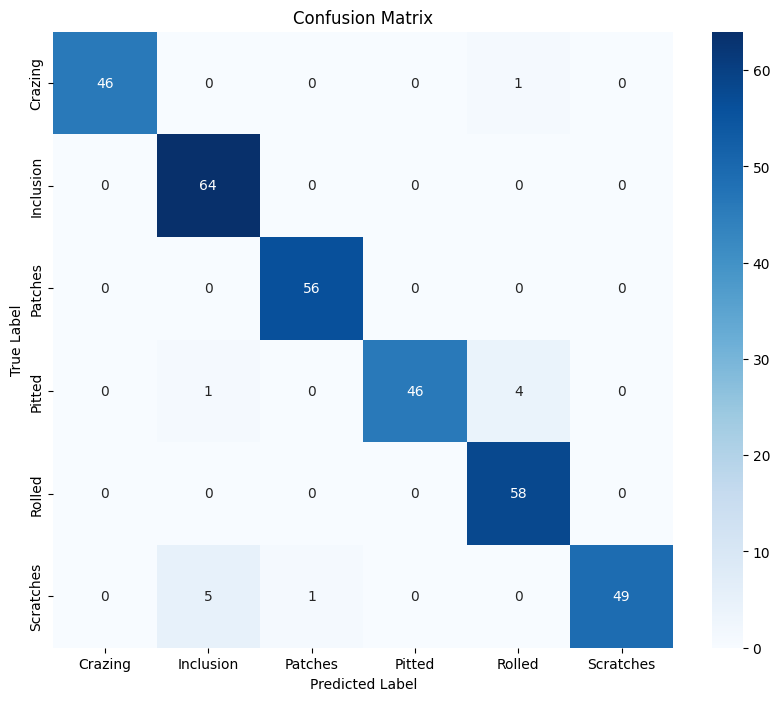

In [23]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images))

y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The matrix gives a detailed breakdown of the model's performance on each class.

We now have a fully trained and evaluated defect detection model!

In [24]:
model.save('defect_classifier_model.h5')
print("Model saved successfully!")

Model saved successfully!
